In [470]:
import re, requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
from gamelogs_to_mongo import format_injury_df
from pymongo import MongoClient
from data_cleaning import *
import matplotlib.pyplot as plt

import string
from collections import Counter
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.util import ngrams
pd.get_option("display.max_columns", 100)

20

In [484]:
df = pd.read_pickle('../data/df_inj.pkl')
df = df[(df['Date'] >= '1994-07-01')&df['New_Inj']]
df

,Date,player,Team,Status,Notes,bbref_id,from,to,height,weight,...,ppg_career_b4,rpg_career_b4,apg_career_b4,pmg_career_b4,League_Years,Num_Inj_Career,Num_Inj_Season,POS_G,POS_F,POS_C
1597,1994-07-06,Patrick Ewing,Knicks,Injured,arthroscopic surgery on knee (out 6-8 weeks),ewingpa01,1986,2002,84,240,...,23.73,10.39,2.15,NaN,8,4,1,0,1,1
1598,1994-08-16,Brent Price,Bullets/Wizards,Injured,surgery on knee to repair torn ACL (out for se...,pricebr01,1993,2002,73,165,...,4.98,1.45,2.76,NaN,2,1,1,1,0,0
1599,1994-08-24,Doug Christie,Lakers,Injured,surgery on left ankle to remove calcium deposi...,chrisdo01,1993,2007,78,200,...,8.85,3.12,2.1,NaN,2,1,1,1,1,0
1600,1994-08-24,John Battle,Cavaliers,Injured,surgery on left knee to remove loose cartilage...,battljo01,1986,1995,74,175,...,8.74,1.39,2.04,NaN,9,2,1,1,0,0
1601,1994-09-15,LaPhonso Ellis,Nuggets,Injured,stress fracture in right kneecap (out 8 weeks),ellisla01,1993,2003,80,240,...,15.01,8.8,1.99,NaN,2,1,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62218,2021-06-06,James Harden,Nets,Injured,placed on IL with tightness in right hamstring,hardeja01,2010,2021,77,220,...,24.92,5.46,6.45,3.82,11,27,7,1,0,0
62219,2021-06-07,Jordan Nwora,Bucks,Injured,placed on IL with left thigh injury,nworajo01,2021,2021,80,225,...,5.5,1.94,0.22,0.03,0,2,2,0,1,0
62221,2021-06-08,Mike Conley,Jazz,Injured,placed on IL with strained right hamstring,conlemi01,2008,2021,73,175,...,15.07,3.04,5.74,1.95,13,46,9,1,0,0
62223,2021-06-09,Sam Merrill,Bucks,Injured,placed on IL with sprained right ankle,merrisa01,2021,2021,76,205,...,2.71,0.91,0.65,-1.15,0,2,2,1,0,0


In [485]:
notes = df.Notes.apply(lambda x: re.sub('/', ' ', x))
notes_list = notes.tolist()
notes#

1597          arthroscopic surgery on knee (out 6-8 weeks)
1598     surgery on knee to repair torn ACL (out for se...
1599     surgery on left ankle to remove calcium deposi...
1600     surgery on left knee to remove loose cartilage...
1601        stress fracture in right kneecap (out 8 weeks)
                               ...                        
62218       placed on IL with tightness in right hamstring
62219                  placed on IL with left thigh injury
62221           placed on IL with strained right hamstring
62223               placed on IL with sprained right ankle
62237                 placed on IL with COVID-19 protocols
Name: Notes, Length: 27212, dtype: object

In [486]:
tokens = notes.apply(lambda x: word_tokenize(x.lower()))
tokens

1597     [arthroscopic, surgery, on, knee, (, out, 6-8,...
1598     [surgery, on, knee, to, repair, torn, acl, (, ...
1599     [surgery, on, left, ankle, to, remove, calcium...
1600     [surgery, on, left, knee, to, remove, loose, c...
1601     [stress, fracture, in, right, kneecap, (, out,...
                               ...                        
62218    [placed, on, il, with, tightness, in, right, h...
62219          [placed, on, il, with, left, thigh, injury]
62221    [placed, on, il, with, strained, right, hamstr...
62223       [placed, on, il, with, sprained, right, ankle]
62237          [placed, on, il, with, covid-19, protocols]
Name: Notes, Length: 27212, dtype: object

[2, 4, 5, 3, 7]

In [498]:
stopwords_ = "a,able,about,across,after,all,almost,also,am,among,an,and,any,\
are,as,at,be,because,been,but,by,can,could,dear,did,do,does,either,\
else,ever,every,for,from,get,got,had,has,have,he,her,hers,him,his,\
how,however,i,if,in,into,is,it,its,just,least,let,like,likely,may,\
me,might,most,must,my,neither,no,of,off,often,on,only,or,other,our,\
own,rather,said,say,says,she,should,since,so,some,than,that,the,their,\
them,then,there,these,they,this,tis,to,too,twas,us,wants,was,we,were,\
what,when,where,which,while,who,whom,why,will,with,would,yet,you,your".split(',')
stopwords_ += ['dnp', 'dtd', 'day-to-day', 'out', 'day', 'season', 'week', 'weeks', 'month', 'months', 'approximate', 'approximately' 'indefinitely', 'placed']

In [546]:
punctuation_ = set(string.punctuation)
def filter_tokens(sent):
    return([w for w in sent if not w in stopwords_ and not w in punctuation_ and not w[0].isnumeric() and (not w[-1].isnumeric() or w == 'covid-19')])
tokens_filtered = tokens.apply(lambda x: filter_tokens(x))
tokens_filtered

1597                         [arthroscopic, surgery, knee]
1598                    [surgery, knee, repair, torn, acl]
1599     [surgery, left, ankle, remove, calcium, deposits]
1600       [surgery, left, knee, remove, loose, cartilage]
1601                    [stress, fracture, right, kneecap]
                               ...                        
62218                    [il, tightness, right, hamstring]
62219                            [il, left, thigh, injury]
62221                     [il, strained, right, hamstring]
62223                         [il, sprained, right, ankle]
62237                            [il, covid-19, protocols]
Name: Notes, Length: 27212, dtype: object

In [528]:
stemmer_porter, stemmer_snowball, lemmatizer = PorterStemmer(), SnowballStemmer('english'),WordNetLemmatizer()
tokens_stemporter = tokens_filtered.apply(lambda x: [stemmer_porter.stem(w) for w in x])
tokens_stemsnowball = tokens_filtered.apply(lambda x: [stemmer_snowball.stem(w) for w in x])
tokens_lemmatizer = tokens_filtered.apply(lambda x: [lemmatizer.lemmatize(w) for w in x])
tokens_lemm_stem = tokens_filtered.apply(lambda x: [stemmer_porter.stem(lemmatizer.lemmatize(w)) for w in x])
tokens_lemm_stem

1597                        [arthroscop, surgeri, knee]
1598                 [surgeri, knee, repair, torn, acl]
1599     [surgeri, left, ankl, remov, calcium, deposit]
1600       [surgeri, left, knee, remov, loos, cartilag]
1601                  [stress, fractur, right, kneecap]
                              ...                      
62218                        [il, tight, right, hamstr]
62219                         [il, left, thigh, injuri]
62221                       [il, strain, right, hamstr]
62223                         [il, sprain, right, ankl]
62237                          [il, covid-19, protocol]
Name: Notes, Length: 27212, dtype: object

In [529]:
stem_lemm_df = pd.DataFrame({'porter':tokens_stemporter, 'snowball':tokens_stemsnowball, 'lemmatizer': tokens_lemmatizer})

stem_lemm_df

,porter,snowball,lemmatizer
1597,"[arthroscop, surgeri, knee]","[arthroscop, surgeri, knee]","[arthroscopic, surgery, knee]"
1598,"[surgeri, knee, repair, torn, acl]","[surgeri, knee, repair, torn, acl]","[surgery, knee, repair, torn, acl]"
1599,"[surgeri, left, ankl, remov, calcium, deposit]","[surgeri, left, ankl, remov, calcium, deposit]","[surgery, left, ankle, remove, calcium, deposit]"
1600,"[surgeri, left, knee, remov, loos, cartilag]","[surgeri, left, knee, remov, loos, cartilag]","[surgery, left, knee, remove, loose, cartilage]"
1601,"[stress, fractur, right, kneecap]","[stress, fractur, right, kneecap]","[stress, fracture, right, kneecap]"
...,...,...,...
62218,"[il, tight, right, hamstr]","[il, tight, right, hamstr]","[il, tightness, right, hamstring]"
62219,"[il, left, thigh, injuri]","[il, left, thigh, injuri]","[il, left, thigh, injury]"
62221,"[il, strain, right, hamstr]","[il, strain, right, hamstr]","[il, strained, right, hamstring]"
62223,"[il, sprain, right, ankl]","[il, sprain, right, ankl]","[il, sprained, right, ankle]"


In [530]:
stem_lemm_df[tokens_stemporter != tokens_stemsnowball]

,porter,snowball,lemmatizer
1604,"[injuri, sinu, caviti, day]","[injuri, sinus, caviti, day]","[injury, sinus, cavity, day]"
1611,"[torn, achil, tendon]","[torn, achill, tendon]","[torn, achilles, tendon]"
1619,"[ruptur, left, achil, tendon]","[ruptur, left, achill, tendon]","[ruptured, left, achilles, tendon]"
1632,"[il, left, achil, tendin]","[il, left, achill, tendin]","[il, left, achilles, tendinitis]"
1712,"[stomach, viru]","[stomach, virus]","[stomach, virus]"
...,...,...,...
62057,"[il, right, achil, injuri]","[il, right, achill, injuri]","[il, right, achilles, injury]"
62061,"[right, achil, injuri]","[right, achill, injuri]","[right, achilles, injury]"
62084,"[il, left, achil, injuri]","[il, left, achill, injuri]","[il, left, achilles, injury]"
62129,"[il, left, achil, injuri]","[il, left, achill, injuri]","[il, left, achilles, injury]"


In [531]:
for token in [tokens_stemporter, tokens_stemsnowball, tokens_lemmatizer]:
    term_occurance = Counter(x for row in token for x in row)
    print(term_occurance.most_common(200),'\n')

[('il', 12539), ('left', 6928), ('right', 6881), ('knee', 4017), ('sprain', 3801), ('ankl', 3405), ('sore', 3134), ('injuri', 2662), ('strain', 2512), ('back', 2004), ('bruis', 1400), ('foot', 1045), ('lower', 892), ('tendin', 860), ('surgeri', 846), ('hamstr', 829), ('shoulder', 756), ('flu', 738), ('rest', 729), ('ill', 713), ('spasm', 711), ('groin', 660), ('indefinit', 618), ('hip', 602), ('calf', 568), ('torn', 526), ('fractur', 524), ('ir', 493), ('achil', 470), ('wrist', 402), ('tendon', 343), ('quadricep', 329), ('toe', 327), ('thumb', 313), ('finger', 290), ('bone', 283), ('hand', 283), ('elbow', 279), ('concuss', 268), ('stomach', 259), ('repair', 257), ('broken', 246), ('leg', 231), ('thigh', 193), ('infect', 189), ('neck', 181), ('nba', 178), ('protocol', 175), ('arthroscop', 174), ('health', 171), ('safeti', 171), ('muscl', 166), ('patella', 165), ('plantar', 165), ('viru', 164), ('big', 163), ('recov', 158), ('heel', 157), ('ligament', 147), ('p', 142), ('stress', 135), (

In [532]:
term_occurance = Counter(x for row in tokens_lemm_stem for x in row)
print(term_occurance.most_common(),'\n')

[('il', 12539), ('left', 6928), ('right', 6881), ('knee', 4017), ('sprain', 3801), ('ankl', 3405), ('sore', 3134), ('injuri', 2662), ('strain', 2512), ('back', 2004), ('bruis', 1400), ('foot', 1059), ('lower', 892), ('tendin', 860), ('surgeri', 846), ('hamstr', 829), ('shoulder', 756), ('flu', 738), ('rest', 729), ('ill', 713), ('spasm', 711), ('groin', 660), ('indefinit', 618), ('hip', 602), ('calf', 568), ('torn', 526), ('fractur', 524), ('ir', 493), ('achil', 470), ('wrist', 402), ('tendon', 343), ('quadricep', 329), ('toe', 327), ('thumb', 313), ('finger', 290), ('bone', 283), ('hand', 283), ('elbow', 279), ('concuss', 268), ('stomach', 259), ('repair', 257), ('broken', 246), ('leg', 231), ('thigh', 193), ('infect', 189), ('neck', 181), ('nba', 178), ('protocol', 175), ('arthroscop', 174), ('health', 171), ('safeti', 171), ('muscl', 166), ('patella', 165), ('plantar', 165), ('viru', 164), ('big', 163), ('recov', 158), ('heel', 157), ('ligament', 147), ('p', 142), ('stress', 135), (

In [609]:
###LEM AND THEN STEM!!!
df_inj_filtered = df.loc[tokens_lemm_stem.apply(lambda x: 
                                                    # ('muscl' in x) and not 
                                                    (
                                                    ## Sick
                                                    ('ill' in x) or 
                                                    ('flu' in x) or 
                                                    ('flu-lik' in x) or 
                                                    ('viru' in x) or 
                                                    ('viral' in x) or 
                                                    ('covid-19' in x) or 
                                                    ('protocol' in x) or 
                                                    ('strep' in x) or 
                                                    ('cold' in x) or
                                                    ('bronchiti' in x) or 
                                                    ('gastroenter' in x) or 
                                                    ('respiratori' in x) or 
                                                    ('poison' in x) or 
                                                    
                                                    ## Rest
                                                    ('rest' in x) or 


                                                    ## Head
                                                    ('headach' in x) or 
                                                    ('migrain' in x) or 
                                                    ('concuss' in x) or 
                                                    ('facial' in x) or 
                                                    ('jaw' in x) or 
                                                    ('throat' in x) or 
                                                    ('head' in x) or 
                                                    ('mouth' in x) or  
                                                    ('oral' in x) or  
                                                    ('tooth' in x) or 
                                                    ('teeth' in x) or 
                                                    ('dental' in x) or 
                                                    ('nose' in x) or 
                                                    ('sinu' in x) or 
                                                    ('eye' in x) or 
                                                    ('ear' in x) or 
                                                    ('eardrum' in x) or 
                                                    
                                                    ## Spine
                                                    ('neck' in x) or 
                                                    ('collarbon' in x) or 
                                                    ('spine' in x) or 
                                                    ('spinal' in x) or 
                                                    ('lumbar' in x) or 
                                                    ('disc' in x) or 
                                                    ('disk' in x) or 
                                                    ('tailbon' in x) or 
                                                    ('back' in x) or 
                                                    

                                                    ## Shoulder
                                                    ('shoulder' in x) or 
                                                    ('cuff' in x) or 
                                                    ('quadricep' in x) or 
                                                    ('bicep' in x) or 
                                                    ('labrum' in x) or

                                                    ## Arm
                                                    ('arm' in x) or 
                                                    ('forearm' in x) or 
                                                    ('elbow' in x) or

                                                    ## Hand
                                                    ('wrist' in x) or 
                                                    ('thumb' in x) or 
                                                    ('hand' in x) or 
                                                    ('finger' in x) or 

                                                    ## Chest
                                                    ('pector' in x) or 
                                                    ('abdomin' in x) or 
                                                    ('chest' in x) or 
                                                    ('rib' in x) or 
                                                    ('obliqu' in x) or
                                                    ('appendectomi' in x) or
                                                    
                                                    ## Heart
                                                    ('heart' in x) or 
                                                    ('heartbeat' in x) or 
                                                    
                                                    ## Midsection
                                                    ('adductor' in x) or 
                                                    ('abductor' in x) or 
                                                    ('pelvi' in x) or 
                                                    ('hip' in x) or 
                                                    ('thigh' in x) or 
                                                    ('groin' in x) or 
                                                    ('hamstr' in x) or 
                                                    
                                                    ('ligament' in x) or 
                                                    ('bone' in x) or
                                                    
                                                    ## LEG
                                                    ('leg' in x) or 
                                                    ('band' in x) or 
                                                    ('tibia' in x) or 
                                                    ('fibula' in x) or 
                                                    
                                                    ## Knee
                                                    ('kene' in x) or 
                                                    ('knee' in x) or 
                                                    ('kneecap' in x) or 
                                                    ('meniscu' in x) or 
                                                    ('acl' in x) or 
                                                    ('patella' in x) or 
                                                    ('mcl' in x) or 
                                                    
                                                    ## Lower Leg
                                                    ('achil' in x) or 
                                                    ('shin' in x) or
                                                    ('calf' in x) or 
                                                    
                                                    ## Ankle
                                                    ('ankl' in x) or 
                                                    ('anke' in x) or 

                                                    ## Foot
                                                    ('plantar' in x) or 
                                                    ('heel' in x) or 
                                                    ('toe' in x) or 
                                                    ('feet' in x) or 
                                                    ('mid-foot' in x) or 
                                                    ('foot' in x)
                                                    )
                                                    # and 
                                                    # (('separ' not in x) and 
                                                    # ('disloc' not in x) and 
                                                    # ('disloact' not in x) and 
                                                    # ('sublax' not in x) and 
                                                    # ('sublux' not in x))
                                                    # and
                                                    # (('swell' not in x) and 
                                                    # ('bursiti' not in x) and 
                                                    # ('inflamm' not in x))
                                                    # and
                                                    # (('strain' not in x) and 
                                                    # ('sprain' not in x) and 
                                                    # ('bruis' not in x) and 
                                                    # ('sore' not in x))
                                                    # and
                                                    # (('surgeri' not in x) and 
                                                    # ('injur' not in x) and 
                                                    # ('injuri' not in x))
                                                    ), :]#.Notes.value_counts()#[:60]
df_inj_filtered

,Date,player,Team,Status,Notes,bbref_id,from,to,height,weight,...,ppg_career_b4,rpg_career_b4,apg_career_b4,pmg_career_b4,League_Years,Num_Inj_Career,Num_Inj_Season,POS_G,POS_F,POS_C
1597,1994-07-06,Patrick Ewing,Knicks,Injured,arthroscopic surgery on knee (out 6-8 weeks),ewingpa01,1986,2002,84,240,...,23.73,10.39,2.15,NaN,8,4,1,0,1,1
1598,1994-08-16,Brent Price,Bullets/Wizards,Injured,surgery on knee to repair torn ACL (out for se...,pricebr01,1993,2002,73,165,...,4.98,1.45,2.76,NaN,2,1,1,1,0,0
1599,1994-08-24,Doug Christie,Lakers,Injured,surgery on left ankle to remove calcium deposi...,chrisdo01,1993,2007,78,200,...,8.85,3.12,2.1,NaN,2,1,1,1,1,0
1600,1994-08-24,John Battle,Cavaliers,Injured,surgery on left knee to remove loose cartilage...,battljo01,1986,1995,74,175,...,8.74,1.39,2.04,NaN,9,2,1,1,0,0
1601,1994-09-15,LaPhonso Ellis,Nuggets,Injured,stress fracture in right kneecap (out 8 weeks),ellisla01,1993,2003,80,240,...,15.01,8.8,1.99,NaN,2,1,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62218,2021-06-06,James Harden,Nets,Injured,placed on IL with tightness in right hamstring,hardeja01,2010,2021,77,220,...,24.92,5.46,6.45,3.82,11,27,7,1,0,0
62219,2021-06-07,Jordan Nwora,Bucks,Injured,placed on IL with left thigh injury,nworajo01,2021,2021,80,225,...,5.5,1.94,0.22,0.03,0,2,2,0,1,0
62221,2021-06-08,Mike Conley,Jazz,Injured,placed on IL with strained right hamstring,conlemi01,2008,2021,73,175,...,15.07,3.04,5.74,1.95,13,46,9,1,0,0
62223,2021-06-09,Sam Merrill,Bucks,Injured,placed on IL with sprained right ankle,merrisa01,2021,2021,76,205,...,2.71,0.91,0.65,-1.15,0,2,2,1,0,0


In [610]:
notes_inj_filtered = df_inj_filtered.Notes.apply(lambda x: re.sub('/', ' ', x))
tokens_inj_filtered = notes_inj_filtered.apply(lambda x: word_tokenize(x.lower()))
tokens_filtered = tokens_inj_filtered.apply(lambda x: filter_tokens(x))
tokens_lemm_stem_filtered = tokens_filtered.apply(lambda x: [stemmer_porter.stem(lemmatizer.lemmatize(w)) for w in x])
term_occurance = Counter(x for row in tokens_lemm_stem_filtered for x in row)
print(term_occurance.most_common(),'\n')

[('il', 6962), ('left', 6887), ('right', 6841), ('knee', 4017), ('sprain', 3790), ('ankl', 3405), ('sore', 3122), ('injuri', 2642), ('strain', 2479), ('back', 2004), ('bruis', 1376), ('foot', 1059), ('lower', 891), ('tendin', 844), ('hamstr', 829), ('surgeri', 818), ('shoulder', 756), ('flu', 738), ('rest', 729), ('ill', 713), ('spasm', 707), ('groin', 660), ('hip', 602), ('indefinit', 598), ('calf', 568), ('torn', 525), ('fractur', 507), ('achil', 470), ('ir', 452), ('wrist', 402), ('tendon', 340), ('quadricep', 329), ('toe', 327), ('thumb', 313), ('finger', 290), ('bone', 283), ('hand', 283), ('elbow', 279), ('concuss', 268), ('broken', 245), ('repair', 240), ('stomach', 235), ('leg', 231), ('thigh', 193), ('neck', 181), ('infect', 177), ('protocol', 175), ('arthroscop', 173), ('nba', 171), ('health', 171), ('safeti', 171), ('patella', 165), ('plantar', 165), ('viru', 164), ('big', 163), ('heel', 157), ('recov', 157), ('muscl', 153), ('ligament', 147), ('mcl', 135), ('stress', 134), 

In [611]:
df_inj_filtered.Notes.value_counts()[:50]

sprained left ankle (DNP)                            571
sprained right ankle (DNP)                           459
flu (DNP)                                            408
placed on IL with sprained left ankle                371
placed on IL with sprained right ankle               325
placed on IL with illness                            275
rest (DTD)                                           274
back spasms (DNP)                                    267
sprained left ankle (DTD)                            240
illness (DTD)                                        235
sprained right ankle (DTD)                           216
placed on IL for rest                                205
placed on IL with back spasms                        188
sore right knee (DNP)                                187
sore left knee (DNP)                                 185
placed on IL with sore right knee                    158
placed on IL with sore left knee                     153
rest (DNP)                     

In [639]:
df_inj_filtered.loc['Illness', :] = tokens_lemm_stem_filtered.apply(lambda x:
                                                                    (
                                                                    ## Sick
                                                                    ('ill' in x) or 
                                                                    ('flu' in x) or 
                                                                    ('flu-lik' in x) or 
                                                                    ('viru' in x) or 
                                                                    ('viral' in x) or 
                                                                    ('covid-19' in x) or 
                                                                    ('protocol' in x) or 
                                                                    ('strep' in x) or 
                                                                    ('cold' in x) or
                                                                    ('bronchiti' in x) or 
                                                                    ('gastroenter' in x) or 
                                                                    ('respiratori' in x) or 
                                                                    ('poison' in x)
                                                                    )
                                                                    ).astype(int)
    
df_inj_filtered.loc['Rest', :] = tokens_lemm_stem_filtered.apply(lambda x: 'rest' in x).astype(int).copy()

df_inj_filtered.loc['On_IL', :] = tokens_lemm_stem_filtered.apply(lambda x: ('il' in x) or ('ir' in x)).astype(int).copy()

df_inj_filtered.loc['Head', :] = tokens_lemm_stem_filtered.apply(lambda x:
                                                                    ## Head
                                                                    ('headach' in x) or 
                                                                    ('migrain' in x) or 
                                                                    ('concuss' in x) or 
                                                                    ('facial' in x) or 
                                                                    ('jaw' in x) or 
                                                                    ('throat' in x) or 
                                                                    ('head' in x) or 
                                                                    ('mouth' in x) or  
                                                                    ('oral' in x) or  
                                                                    ('tooth' in x) or 
                                                                    ('teeth' in x) or 
                                                                    ('dental' in x) or 
                                                                    ('nose' in x) or 
                                                                    ('sinu' in x) or 
                                                                    ('eye' in x) or 
                                                                    ('ear' in x) or 
                                                                    ('eardrum' in x)                                                                  
                                                                    ).astype(int).copy()


df_inj_filtered.loc['Spine', :] = tokens_lemm_stem_filtered.apply(lambda x:
                                                                    ## Spine
                                                                    ('neck' in x) or 
                                                                    ('collarbon' in x) or 
                                                                    ('spine' in x) or 
                                                                    ('spinal' in x) or 
                                                                    ('lumbar' in x) or 
                                                                    ('disc' in x) or 
                                                                    ('disk' in x) or 
                                                                    ('tailbon' in x) or 
                                                                    ('back' in x)
                                                                    ).astype(int)

df_inj_filtered.loc['Shoulder', :] = tokens_lemm_stem_filtered.apply(lambda x:
                                                                    ## Shoulder
                                                                    ('shoulder' in x) or 
                                                                    ('cuff' in x) or 
                                                                    ('quadricep' in x) or 
                                                                    ('bicep' in x) or 
                                                                    ('labrum' in x)
                                                                    ).astype(int).copy()

df_inj_filtered.loc['Arm', :] = tokens_lemm_stem_filtered.apply(lambda x:
                                                                    ## Arm
                                                                    ('arm' in x) or 
                                                                    ('forearm' in x) or 
                                                                    ('elbow' in x)
                                                                    ).astype(int).copy()

df_inj_filtered.loc['Hand', :] = tokens_lemm_stem_filtered.apply(lambda x:
                                                                    ## Hand
                                                                    ('wrist' in x) or 
                                                                    ('thumb' in x) or 
                                                                    ('hand' in x) or 
                                                                    ('finger' in x)
                                                                    ).astype(int).copy()

df_inj_filtered.loc['Chest', :] = tokens_lemm_stem_filtered.apply(lambda x:
                                                                    ## Chest
                                                                    ('pector' in x) or 
                                                                    ('abdomin' in x) or 
                                                                    ('chest' in x) or 
                                                                    ('rib' in x) or 
                                                                    ('obliqu' in x) or
                                                                    ('appendectomi' in x)
                                                                    ).astype(int).copy()

df_inj_filtered.loc['Heart', :] = tokens_lemm_stem_filtered.apply(lambda x:
                                                                    ## Heart
                                                                    ('heart' in x) or 
                                                                    ('heartbeat' in x)
                                                                    ).astype(int).copy()

df_inj_filtered.loc['Midsection', :] = tokens_lemm_stem_filtered.apply(lambda x:
                                                                    ## Midsection
                                                                    ('adductor' in x) or 
                                                                    ('abductor' in x) or 
                                                                    ('pelvi' in x) or 
                                                                    ('hip' in x) or 
                                                                    ('thigh' in x) or 
                                                                    ('groin' in x) or 
                                                                    ('hamstr' in x)
                                                                    ).astype(int).copy()
                                                                    
                                                                    
df_inj_filtered.loc['Leg', :] = tokens_lemm_stem_filtered.apply(lambda x:
                                                                    ## LEG
                                                                    ('leg' in x) or 
                                                                    ('band' in x) or 
                                                                    ('tibia' in x) or 
                                                                    ('fibula' in x)
                                                                    ).astype(int).copy()
                                                                    
df_inj_filtered.loc['Knee', :] = tokens_lemm_stem_filtered.apply(lambda x:
                                                                    ## Knee
                                                                    ('kene' in x) or 
                                                                    ('knee' in x) or 
                                                                    ('kneecap' in x) or 
                                                                    ('meniscu' in x) or 
                                                                    ('acl' in x) or 
                                                                    ('patella' in x) or 
                                                                    ('mcl' in x)
                                                                    ).astype(int).copy()
                                                            
df_inj_filtered.loc['Low_Leg', :] = tokens_lemm_stem_filtered.apply(lambda x:
                                                                    ## Lower Leg
                                                                    ('achil' in x) or 
                                                                    ('shin' in x) or
                                                                    ('calf' in x)
                                                                    ).astype(int).copy()
                                                                    
df_inj_filtered.loc['Ankle', :] = tokens_lemm_stem_filtered.apply(lambda x:
                                                                    ## Ankle
                                                                    ('ankl' in x) or 
                                                                    ('anke' in x)
                                                                    ).astype(int).copy()

df_inj_filtered.loc['Foot', :] = tokens_lemm_stem_filtered.apply(lambda x:
                                                                    ## Foot
                                                                    ('plantar' in x) or 
                                                                    ('heel' in x) or 
                                                                    ('toe' in x) or 
                                                                    ('feet' in x) or 
                                                                    ('mid-foot' in x) or 
                                                                    ('foot' in x)
                                                                    ).astype(int).copy()
df_inj_filtered
# .iloc[:, -16:].sum(axis=0)

,Date,player,Team,Status,Notes,bbref_id,from,to,height,weight,...,Arm,Hand,Chest,Heart,Midsection,Leg,Knee,Low_Leg,Ankle,Foot
1597,1994-07-06 00:00:00,Patrick Ewing,Knicks,Injured,arthroscopic surgery on knee (out 6-8 weeks),ewingpa01,1986.0,2002.0,84.0,240.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1598,1994-08-16 00:00:00,Brent Price,Bullets/Wizards,Injured,surgery on knee to repair torn ACL (out for se...,pricebr01,1993.0,2002.0,73.0,165.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1599,1994-08-24 00:00:00,Doug Christie,Lakers,Injured,surgery on left ankle to remove calcium deposi...,chrisdo01,1993.0,2007.0,78.0,200.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1600,1994-08-24 00:00:00,John Battle,Cavaliers,Injured,surgery on left knee to remove loose cartilage...,battljo01,1986.0,1995.0,74.0,175.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1601,1994-09-15 00:00:00,LaPhonso Ellis,Nuggets,Injured,stress fracture in right kneecap (out 8 weeks),ellisla01,1993.0,2003.0,80.0,240.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62219,2021-06-07 00:00:00,Jordan Nwora,Bucks,Injured,placed on IL with left thigh injury,nworajo01,2021.0,2021.0,80.0,225.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
62221,2021-06-08 00:00:00,Mike Conley,Jazz,Injured,placed on IL with strained right hamstring,conlemi01,2008.0,2021.0,73.0,175.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
62223,2021-06-09 00:00:00,Sam Merrill,Bucks,Injured,placed on IL with sprained right ankle,merrisa01,2021.0,2021.0,76.0,205.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
62237,2021-06-16 00:00:00,Chris Paul,Suns,Injured,placed on IL with COVID-19 protocols,paulch01,2006.0,2021.0,72.0,175.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

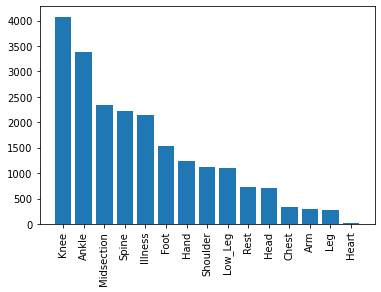

In [635]:
# df_inj_filtered.iloc[:, -16:].sum(axis=0).sort_values(ascending=False)[1:]
temp = df_inj_filtered.iloc[:, -16:].sum(axis=0).sort_values(ascending=False)[1:]
plt.bar(temp.index,temp.values)
plt.xticks(rotation=90);

In [580]:
df_inj_filtered[tokens_lemm_stem_filtered.apply(lambda x: not (
                                                    # Soft Tissue 1
                                                    ('sore' in x) or
                                                    ('tight' in x) or
                                                    ('stiff' in x) or
                                                    ('stretch' in x) or
                                                    ('jam' in x) or
                                                    ('twist' in x) or
                                                    ('pull' in x) or
                                                    
                                                    ## Soft Tissue 2
                                                    ('sublux' in x) or
                                                    ('sublex' in x) or
                                                    ('sublax' in x) or
                                                    ('hyperextend' in x) or
                                                    ('hyper-extend' in x) or
                                                    ('pointer' in x) or
                                                    ('tendin' in x) or
                                                    ('spasm' in x) or
                                                    
                                                    ## Dislocation
                                                    ('disloc' in x) or
                                                    ('disloact' in x) or
                                                    ('separ' in x) or
                                                    
                                                    ## Concussion
                                                    ('concuss' in x) or

                                                    ## Swell
                                                    ('bursiti' in x) or
                                                    ('inflam' in x) or
                                                    ('inflamm' in x) or
                                                    ('swell' in x) or
                                                    ('swollen' in x) or
                                                    ('bruis' in x) or
                                                    ('contus' in x) or
                                                    
                                                    ## Sprain/Strain
                                                    ('sprain' in x) or
                                                    ('spain' in x) or
                                                    ('strain' in x) or
                                                    ('stain' in x) or

                                                    ## Tear/Break
                                                    ('stress' in x) or
                                                    ('broken' in x) or
                                                    ('broke' in x) or
                                                    ('fractur' in x) or
                                                    ('torn' in x) or
                                                    ('tear' in x) or
                                                    ('ruptur' in x) or

                                                    ## Cut
                                                    ('abras' in x) or
                                                    ('lacer' in x) or
                                                    ('cut' in x) or

                                                    # ('nerv' in x) or
                                                    # ('bone' in x) or
                                                    # ('bronchiti' in x) or ####
                                                    # ('gastroenter' in x) or ####
                                                    # ('respiratori' in x) or ####
                                                    # ('injuri' in x) or#####
                                                    # ('injur' in x) or#####
                                                    # ('problem' in x) or#####
                                                    # ('protocol' in x) or#####
                                                    # ('viral' in x) or#####
                                                    # ('viru' in x) or#####
                                                    # ('poison' in x) or#####
                                                    # ('strep' in x) or#####
                                                    # ('migrain' in x) or#####
                                                    # ('headach' in x) or#####
                                                    # ('illness' in x) or ####
                                                    # ('ill' in x) or ####
                                                    # ('covid-19' in x) or ####
                                                    # ('flu' in x) or ####
                                                    # ('flu-lik' in x) or ####
                                                    # ('infect' in x) or ####
                                                    # ('cold' in x) or ####
                                                    
                                                    # ('rest' in x) or ####

                                                    # ('pain' in x) or ####
                                                    # ('heart' in x) or ####
                                                    # ('heartbeat' in x) or ####

                                                    ## Hospitalized/Surgery
                                                    ('appendectomi' in x) or
                                                    ('hospit' in x) or ####
                                                    ('surguri' in x) or
                                                    ('surgeri' in x)
                                                    ))].Notes.value_counts()

appendectomy (out indefinitely)                                                                                           7
bulging disc in lower back (DNP)                                                                                          6
placed on IL with turf toe                                                                                                6
bulging disc in back (DNP)                                                                                                5
placed on IL with shin splints                                                                                            4
                                                                                                                         ..
dental work (DTD)                                                                                                         1
appendectomy (out for season)                                                                                             1
placed o

In [569]:
from nltk import pos_tag

sent_tags = list(map(pos_tag, tokens_stemporter))

for sent in sent_tags:
    print("--- sentence tags: {}".format(sent))

N')]
--- sentence tags: [('il', 'JJ'), ('nba', 'JJ'), ('health', 'NN'), ('safeti', 'NN'), ('protocol', 'NN')]
--- sentence tags: [('il', 'NN'), ('toe', 'NN'), ('injuri', 'NN')]
--- sentence tags: [('il', 'NN'), ('sore', 'VBD'), ('lower', 'JJR'), ('back', 'NN')]
--- sentence tags: [('right', 'JJ'), ('knee', 'NN'), ('inflamm', 'NN')]
--- sentence tags: [('il', 'RB'), ('right', 'JJ'), ('knee', 'NN'), ('injuri', 'NN')]
--- sentence tags: [('il', 'NN'), ('tibia', 'NN'), ('injuri', 'NN')]
--- sentence tags: [('il', 'NN'), ('sore', 'RB'), ('right', 'JJ'), ('knee', 'NN')]
--- sentence tags: [('left', 'VBN'), ('hip', 'NN'), ('flexor', 'NN'), ('injuri', 'NN')]
--- sentence tags: [('il', 'JJ'), ('nba', 'JJ'), ('health', 'NN'), ('safeti', 'NN'), ('protocol', 'NN')]
--- sentence tags: [('right', 'JJ'), ('hamstr', 'NN'), ('injuri', 'NN')]
--- sentence tags: [('il', 'NN'), ('ill', 'NN')]
--- sentence tags: [('il', 'NN'), ('sore', 'RB'), ('right', 'JJ'), ('knee', 'NN')]
--- sentence tags: [('sore', 'N

In [283]:
bodyparts= set()
for sent in sent_tags:
    tags_filtered = [t for t in sent if t[1].startswith('NN') and ((t[0]!='il') and 
                                                                    (t[0]!='dtd') and
                                                                    (t[0]!='health') and
                                                                    (t[0]!='safety') and
                                                                    (t[0]!='protocols') and
                                                                    (t[0]!='injury')
                                                                    )]

    if tags_filtered != []:
        for tag in tags_filtered:
            bodyparts.add(tag[0])
        # print("--- bodyparts:\n{}".format(tags_filtered))
print(bodyparts)

{'ailment', 'fouls', 'sacroliac', 'bulls', 'place', 'pinkie', 'shoulder', 'lumbar', 'hair', 'aorta', 'vertigo', 'lightheadedness', 'irritation', 'media', 'viris', 'microdisectomy', 'wth', 'tendintis', 'salmonella', 'plantar', 'foot', 'hamstringt', 'stomach', 'insert', 'need', 'dnp', 'papers', 'fascia', 'spurs', 'removal', 'pull', 'plica', 'places', 'playoff', 'sister', 'tarsel', 'scar', 'toenail', 'march', 'abuse', 'gastroentritis', 'joint', 'surery', 'strain', 'flu', 'deltoid', 'torn', 'deposit', 'microfracture', 'face', 'feet', 'muscle', 'trauma', 'clavicle', 'relieve', 'compression', 'calcium', 'suspension', 'quadricap', 'appendectomy', 'corneal', 'ribs', 'orbital', 'tibula', 'stats', 'problem', 'bulging', 'pubalgia', 'sprain', 'rash', 'hives', 'bronchitis', 'regular', 'anemia', 'labor', 'guide', 'disk', 'fluid', 'faciitis', 'covid-19', 'migraine', 'hamstring', 'spinal', 'resting', 'reconstruct', 'pectoralis', 'eyes', 'week', 'chronic', 'deficiency', 'synovititis', '~cbc', 'biceps',

In [310]:
def join_sent_ngrams(input_tokens, n):
    # first add the 1-gram tokens
    ret_list = list(input_tokens)
    
    #then for each n
    for i in range(2,n+1):
        # add each n-grams to the list
        ret_list.extend(['-'.join(tgram) for tgram in ngrams(input_tokens, i)])
    
    return(ret_list)
tokens_ngrams = list(map(lambda x : join_sent_ngrams(x, 2), tokens_stemporter))
# tokens_ngrams

In [312]:
term_occurance = Counter(x for row in tokens_ngrams for x in row)
print(term_occurance.most_common(500))


[('place', 13033), ('il', 12539), ('place-il', 12539), ('dnp', 8051), ('left', 6928), ('right', 6881), ('dtd', 4184), ('knee', 4017), ('sprain', 3801), ('ankl', 3405), ('sore', 3134), ('injuri', 2662), ('strain', 2512), ('back', 2004), ('out', 1939), ('left-knee', 1813), ('sprain-left', 1764), ('right-knee', 1756), ('sprain-right', 1681), ('left-ankl', 1676), ('right-ankl', 1455), ('bruis', 1400), ('ankl-dnp', 1225), ('sore-left', 1189), ('il-sprain', 1188), ('sore-right', 1125), ('foot', 1045), ('il-sore', 973), ('knee-dnp', 928), ('lower', 892), ('season', 889), ('out-season', 885), ('strain-left', 880), ('tendin', 860), ('strain-right', 858), ('surgeri', 846), ('hamstr', 829), ('il-strain', 829), ('lower-back', 828), ('injuri-dtd', 792), ('shoulder', 756), ('flu', 738), ('rest', 729), ('ill', 713), ('spasm', 711), ('back-spasm', 670), ('groin', 660), ('indefinit', 618), ('out-indefinit', 617), ('hip', 602), ('knee-injuri', 583), ('ankl-dtd', 580), ('bruis-right', 569), ('calf', 568)

In [205]:
nsc = notes_new.str.contains
## Injury type: Dislocation, torn, surgery, ruptured, stretched, hyperextended, separated, rest
notes_new[(nsc('health', case=False)|nsc('protocol', case=False)|nsc('COVID', case=False))] ### COVID
notes_new[(nsc('^ill', case=False)|nsc('illn', case=False))&nsc('chill', case=False)].values ## Illness
# notes_new[nsc('infec', case=False)].value_counts() ## Infection
# notes_new[nsc('broke', case=False)|nsc('frac', case=False)] ## Broken
# notes_new[nsc('sprain', case=False)] ## Sprain
# notes_new[nsc('strain', case=False)&~nsc('sprain', case=False)] ## Sprain
# notes_new[nsc('brus', case=False)|nsc('bruis', case=False)|nsc('contu', case=False)] ## bruise
# notes_new[nsc('sore', case=False)] ## Sore
# notes_new[nsc('sick', case=False)] ## Sore
notes_new[nsc('feet', case=False)]

NameError: name 'notes_new' is not defined

In [206]:
temp_players = set(df[((notes == 'placed on IL') & (df.New_Inj == 1))]['bbref_id'].unique().tolist())

df[((notes == 'placed on IL') & (df.New_Inj == 1))|((df.New_Inj != 1)&df.bbref_id.isin(temp_players))].tail(40)

,Date,player,Team,Status,Notes,bbref_id,from,to,height,weight,...,ppg_career_b4,rpg_career_b4,apg_career_b4,pmg_career_b4,League_Years,Num_Inj_Career,Num_Inj_Season,POS_G,POS_F,POS_C
59356,2020-08-01,Gabe Vincent,Heat,Injured,placed on IL,vincega01,2020,2021,75,200,...,2.0,0.5,0.5,-1.2,0,6,6,1,0,0
59409,2020-08-07,Zion Williamson,Hornets/Pelicans,Injured,placed on IL,willizi01,2020,2021,79,284,...,22.39,6.22,2.13,3.61,0,3,3,0,1,1
59535,2020-08-14,Tyson Chandler,Rockets,Injured,placed on IL,chandty01,2002,2020,84,235,...,8.12,8.98,0.81,0.35,18,63,4,0,0,1
59654,2020-12-22,Frank Kaminsky,Suns,Injured,placed on IL,kaminfr01,2016,2021,84,240,...,9.71,4.05,1.63,-0.03,5,7,1,0,1,1
59658,2020-12-22,Kostas Antetokounmpo,Lakers,Injured,placed on IL,antetko01,2019,2021,82,200,...,1.29,0.57,0.29,1.43,2,8,1,0,1,0
59673,2020-12-23,Jarrell Brantley,Jazz,Injured,placed on IL,brantja01,2020,2021,77,250,...,2.27,2.18,1.18,-4.18,1,1,1,0,1,0
59676,2020-12-23,Jordan McLaughlin,Timberwolves,Injured,placed on IL,mclaujo01,2020,2021,71,185,...,7.63,1.63,4.17,-2.33,1,1,1,1,0,0
59691,2020-12-23,Devon Dotson,Bulls,Injured,placed on IL,dotsode01,2021,2021,74,185,...,NaN,NaN,NaN,NaN,0,1,1,1,0,0
59709,2020-12-26,Trevor Ariza,Sonics/Thunder,Injured,placed on IL,arizatr01,2005,2021,80,215,...,10.52,4.83,2.13,0.82,16,39,1,0,1,0
59735,2020-12-27,Jaylen Adams,Bucks,Injured,placed on IL,adamsja01,2019,2021,72,225,...,3.08,1.7,1.81,-0.95,2,7,1,1,0,0


In [207]:

# df[tokens_stemporter.apply(lambda x: ('il' not in x) or ('ir' not in x))]
df[tokens_stemporter.apply(lambda x:('place' in x) and ('il' not in x) and ('ir' not in x))].Notes.values
tokens_stemporter[tokens_stemporter.apply(lambda x: (('shoulder' in x) )
                                                    # ('bicep' in x) or 
                                                    # ('cuff' in x)) 
                                                    and 
                                                    # (('separ' not in x) and 
                                                    # ('disloc' not in x) and 
                                                    # ('disloact' not in x) and 
                                                    # ('sublax' not in x) and 
                                                    # ('sublux' not in x))
                                                    # and
                                                    # (('swell' not in x) and 
                                                    # ('bursiti' not in x) and 
                                                    # ('inflamm' not in x))
                                                    # and
                                                    # (('strain' not in x) and 
                                                    # ('sprain' not in x) and 
                                                    # ('bruis' not in x) and 
                                                    # ('sore' not in x))
                                                    # and
                                                    # (('surgeri' not in x) and 
                                                    # ('injur' not in x) and 
                                                    # ('injuri' not in x))
                                                    )]
# Swell, bursiti, inflamm
# separ, disloc, sublux


1659         [place, il, separ, right, shoulder]
1680     [place, il, strain, right, rotat, cuff]
1767                     [strain, shoulder, dnp]
1902          [disloc, shoulder, out, 6-8, week]
1912                     [strain, shoulder, dnp]
                          ...                   
61483          [place, il, sore, left, shoulder]
61555       [place, il, left, shoulder, inflamm]
61654       [place, il, bursiti, left, shoulder]
61691               [sore, right, shoulder, dtd]
61776        [place, il, sprain, left, shoulder]
Name: Notes, Length: 780, dtype: object

In [210]:
tokens_stemporter[tokens_stemporter.apply(lambda x: (('disc' in x) or 
                                                    ('back' in x) or 
                                                    ('spine' in x)) 
                                                    # and 
                                                    # (('separ' not in x) and 
                                                    # ('disloc' not in x) and 
                                                    # ('disloact' not in x) and 
                                                    # ('sublax' not in x) and 
                                                    # ('sublux' not in x))
                                                    # and
                                                    # (('swell' not in x) and 
                                                    # ('bursiti' not in x) and 
                                                    # ('inflamm' not in x))
                                                    # and
                                                    # (('strain' not in x) and 
                                                    # ('sprain' not in x) and 
                                                    # ('bruis' not in x) and 
                                                    # ('sore' not in x))
                                                    # and
                                                    # (('surgeri' not in x) and 
                                                    # ('injur' not in x) and 
                                                    # ('injuri' not in x))
                                                    )]

1603                         [back, problem]
1613     [sore, back, out, rest, pre-season]
1630              [place, il, surgeri, back]
1639                 [place, il, sore, back]
1640                 [place, il, sore, back]
                        ...                 
62109              [tight, lower, back, dtd]
62117                    [back, injuri, dtd]
62118         [place, il, sore, lower, back]
62140              [place, il, back, injuri]
62146                   [spine, injuri, dtd]
Name: Notes, Length: 2012, dtype: object

In [256]:
# notes[notes.str.contains('feet')&~notes.str.contains('foot')]
notes[
    notes.str.contains('knee') # Knee
    | notes.str.contains('ankl') # Ankle
    | notes.str.contains('wrist') # Hand
    | notes.str.contains('finger') # Hand
    | notes.str.contains('back') # Back
    | notes.str.contains('arm') # Arm
    | notes.str.contains('shoulder') # Shoulder
    | notes.str.contains('cuff') # Shoulder
    | notes.str.contains('foot') # Foot
    | notes.str.contains('eye') # Face
    | notes.str.contains('eye') # Face

    # | notes.str.contains('flu') # Sick
    # | notes.str.contains('ill') # Sick
    # | notes.str.contains('rest') # Sick
    ].value_counts()
notes[tokens_stemporter.apply(lambda x: ('flu' in x))].value_counts()

flu (DNP)                                                      408
placed on IL with flu                                          137
flu (DTD)                                                       73
stomach flu (DNP)                                               46
placed on IL with stomach flu                                    9
stomach flu (DTD)                                                4
placed on IL flu                                                 4
placed on IL with illness flu                                    3
sore throat   flu (DNP)                                          2
placed on IL with flu   stomach virus                            2
gastrointestinal flu (DNP)                                       2
flu   stomach virus (DNP)                                        2
sore left foot (P)   flu (CBC) (DNP)                             1
placed on IR with gastroenteritis (stomach flu) and vertigo      1
placed on IL with flu (P)   thumb injury (CBC)                

In [234]:
for k, v in notes.apply(lambda x: re.sub('( \(.*?\))', '', x)).value_counts().to_dict().items():
    if v > 4:
        print(k, v)

placed on IL 5426
sprained left ankle 863
sprained right ankle 735
flu 483
rest 432
placed on IL with sprained left ankle 395
back spasms 361
placed on IL with sprained right ankle 337
sore right knee 324
sore left knee 324
illness 322
placed on IL with illness 280
placed on IL for rest 211
placed on IL with back spasms 191
sore lower back 178
placed on IL with sore right knee 167
placed on IL with sore left knee 166
concussion 156
strained right hamstring 143
DNP 142
placed on IL with strained lower back 139
placed on IL with flu 139
strained left hamstring 136
sore back 135
strained lower back 133
knee injury 127
placed on IL with NBA health and safety protocols 124
bruised right knee 118
strained left groin 118
placed on IL with left knee tendinitis 115
stomach virus 114
placed on IL with right knee tendinitis 114
right knee injury 113
sore left ankle 110
bruised left knee 104
strained right groin 103
back injury 100
left knee injury 99
sore right ankle 94
strained left calf 92
spra